In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [134]:
days = 7
hours = 24

data = []

for d in range(days):
    for h in range(hours):

        if 0 <= h < 6:
            base = 40
        elif 6 <= h < 10:
            base = 200
        elif 10 <= h < 17:
            base = 520
        elif 17 <= h < 21:
            base = 350
        else:
            base = 150

        noise = np.random.randint(-40,40)
        users = base + noise

        data.append([d+1, h, users])

df = pd.DataFrame(data, columns=["Day","Hour","Users"])

df.to_csv("7day_traffic_dataset.csv", index=False)

print("Dataset Saved Successfully")
print(df.head())

Dataset Saved Successfully
   Day  Hour  Users
0    1     0     38
1    1     1     11
2    1     2     24
3    1     3     30
4    1     4     69


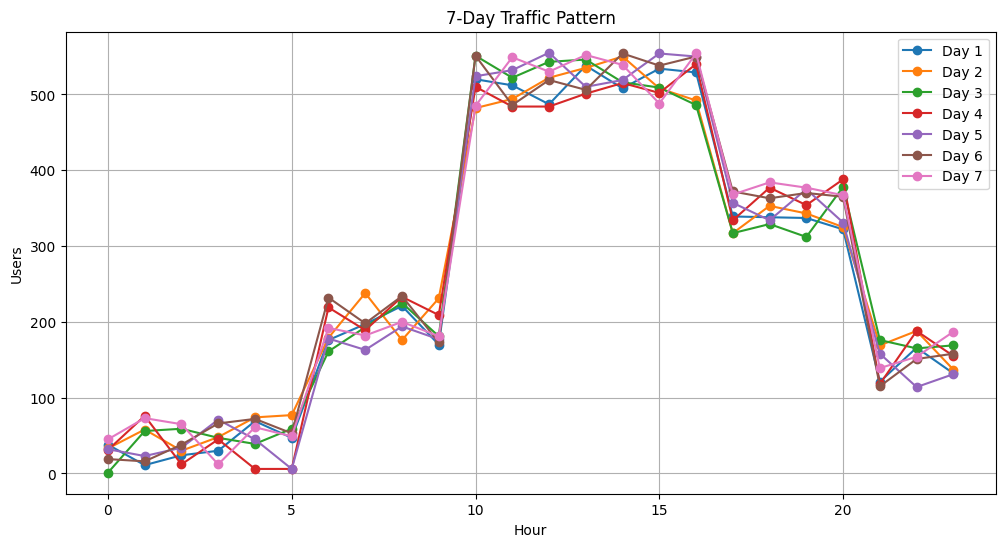

In [135]:
plt.figure(figsize=(12,6))

for d in range(1,8):
    day_data = df[df["Day"]==d]
    plt.plot(day_data["Hour"], day_data["Users"], marker='o', label=f"Day {d}")

plt.title("7-Day Traffic Pattern")
plt.xlabel("Hour")
plt.ylabel("Users")
plt.legend()
plt.grid()

plt.show()

In [136]:
df["Hour_sin"] = np.sin(2*np.pi*df["Hour"]/24)
df["Hour_cos"] = np.cos(2*np.pi*df["Hour"]/24)

In [137]:

X = df[["Day","Hour_sin","Hour_cos"]]
y = df["Users"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

print("Model Training Completed")

Model Training Completed


In [138]:
y_pred = model.predict(X_test)

error = mean_absolute_error(y_test, y_pred)

print("Prediction Error:", error)

Prediction Error: 44.84291790720179


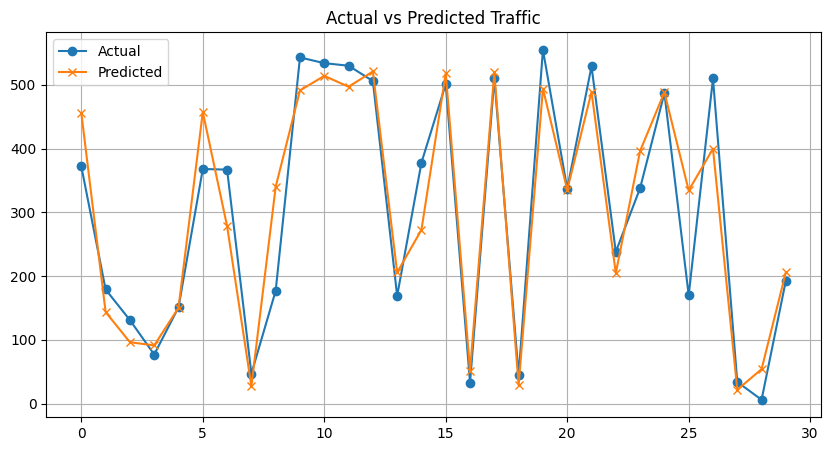

In [139]:
plt.figure(figsize=(10,5))

plt.plot(y_test.values[:30], label="Actual", marker='o')
plt.plot(y_pred[:30], label="Predicted", marker='x')

plt.title("Actual vs Predicted Traffic")
plt.legend()
plt.grid()

plt.show()

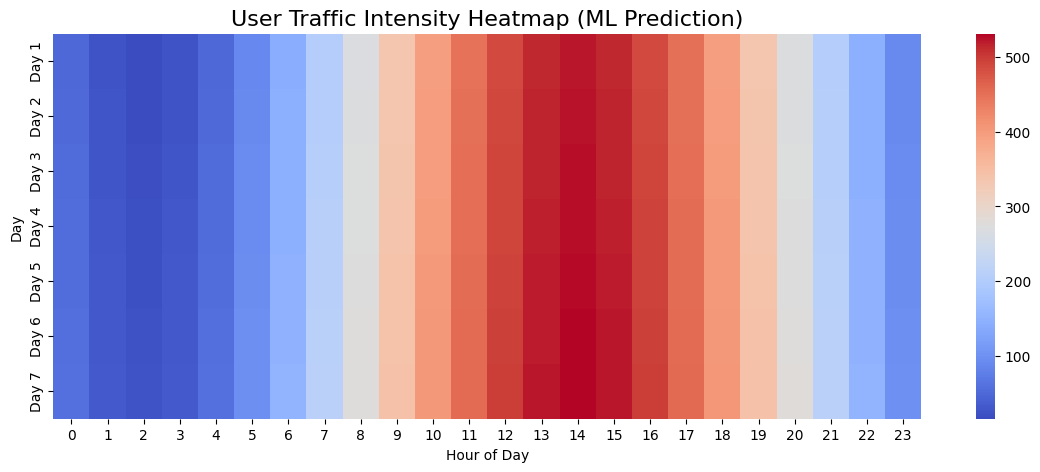

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create continuous data (flatten all days into one long timeline)
heat_data = []

for d in range(1, 8):
    for h in range(24):

        test = pd.DataFrame({
            "Day":[d],
            "Hour_sin":[np.sin(2*np.pi*h/24)],
            "Hour_cos":[np.cos(2*np.pi*h/24)]
        })

        pred_users = model.predict(test)[0]
        heat_data.append(pred_users)

# Convert to 2D (Day vs Hour)
heat_array = np.array(heat_data).reshape(7, 24)

# Plot smooth heatmap
plt.figure(figsize=(14,5))

sns.heatmap(
    heat_array,
    cmap="coolwarm",     # gradient like your image
    cbar=True,
    linewidths=0,        # remove boxes
    xticklabels=range(24),
    yticklabels=[f"Day {i}" for i in range(1,8)]
)

plt.title("User Traffic Intensity Heatmap (ML Prediction)", fontsize=16)
plt.xlabel("Hour of Day")
plt.ylabel("Day")

plt.show()

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(10,5))

line, = ax.plot([], [], lw=3)

ax.set_xlim(0, 23)
ax.set_ylim(0, 600)

ax.set_title("Real-Time Traffic & Cell Mode (ML Based)")
ax.set_xlabel("Hour")
ax.set_ylabel("Users")
ax.grid()

def update(frame):

    users_list = []

    for h in range(frame + 1):

        test = pd.DataFrame({
            "Day":[3],
            "Hour_sin":[np.sin(2*np.pi*h/24)],
            "Hour_cos":[np.cos(2*np.pi*h/24)]
        })

        pred = model.predict(test)[0]
        users_list.append(pred)

    current_users = users_list[-1]
    mode = cell_mode(current_users)

    if mode == "ON":
        line.set_color("red")
    elif mode == "IDLE":
        line.set_color("orange")
    else:
        line.set_color("blue")

    line.set_data(range(len(users_list)), users_list)

    return line,

anim = FuncAnimation(fig, update, frames=24, interval=400)

# SAVE GIF
anim.save("traffic_animation.gif", writer=PillowWriter(fps=2))

# ❗ VERY IMPORTANT LINE (REMOVE EMPTY GRAPH)
plt.close(fig)

print("Animation saved successfully!")

Animation saved successfully!


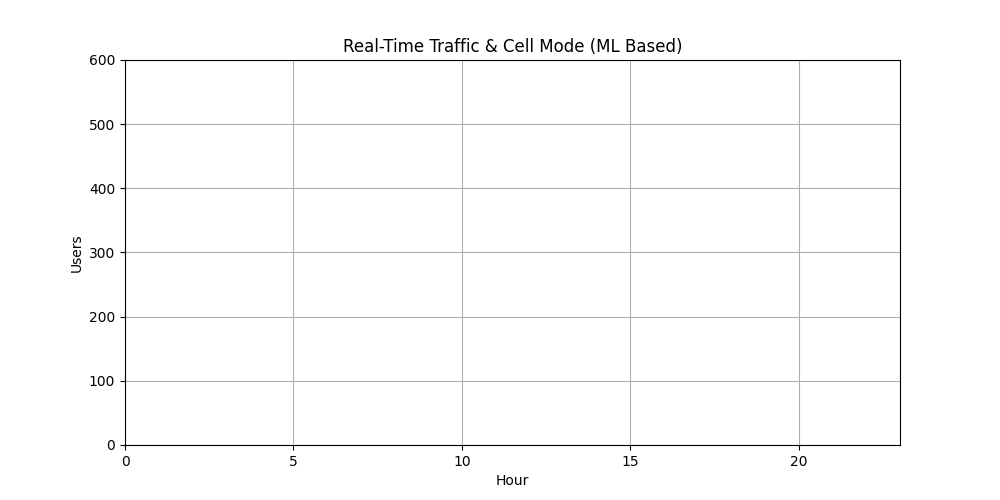

In [142]:
from IPython.display import Image
Image("traffic_animation.gif")

In [143]:
def cell_mode(predicted_users):

    if predicted_users > 350:
        return "ON"
    elif predicted_users > 180:
        return "IDLE"
    elif predicted_users > 80:
        return "LIGHT_SLEEP"
    else:
        return "DEEP_SLEEP"

In [144]:
def old_system_mode(users):

    if users > 300:
        return "ON"
    elif users > 150:
        return "IDLE"
    else:
        return "SLEEP"

In [145]:
POWER_ON = 120
POWER_IDLE = 70
POWER_SLEEP = 15

MAX_CAPACITY = 450

In [146]:
old_power = 0
new_power = 0

total_data = 0
outage_old = 0
outage_new = 0

for index, row in df.iterrows():

    users = row["Users"]

    # OLD SYSTEM MODE
    old_mode = old_system_mode(users)

    # OLD SYSTEM POWER (more variation ±10%)
    if old_mode == "ON":
        old_power += POWER_ON * (1 + np.random.uniform(-0.1, 0.1))
    elif old_mode == "IDLE":
        old_power += POWER_IDLE * (1 + np.random.uniform(-0.1, 0.1))
    else:
        old_power += POWER_SLEEP * (1 + np.random.uniform(-0.1, 0.1))


    # NEW SYSTEM (ML)
    test = pd.DataFrame({
        "Day":[row["Day"]],
        "Hour_sin":[np.sin(2*np.pi*row["Hour"]/24)],
        "Hour_cos":[np.cos(2*np.pi*row["Hour"]/24)]
    })

    pred_users = model.predict(test)[0]
    new_mode = cell_mode(pred_users)

    # NEW SYSTEM POWER (less variation ±5%)
    if new_mode == "ON":
        new_power += POWER_ON * (1 + np.random.uniform(-0.05, 0.05))
    elif new_mode == "IDLE":
        new_power += POWER_IDLE * (1 + np.random.uniform(-0.05, 0.05))
    else:
        new_power += POWER_SLEEP * (1 + np.random.uniform(-0.05, 0.05))


    # DATA (throughput assumption)
    total_data += users * 10


    # ⭐ REALISTIC OUTAGE LOGIC

    # OLD SYSTEM (more failures)
    if users > 350 and old_mode != "ON":
        outage_old += 1
    elif users > 300 and np.random.rand() < 0.1:
        outage_old += 1

    # NEW SYSTEM (smarter, fewer failures)
    if pred_users > 400 and new_mode != "ON":
        outage_new += 1
    elif pred_users > 350 and np.random.rand() < 0.05:
        outage_new += 1

In [147]:
total_hours = len(df)

energy_eff_old = total_data / old_power
energy_eff_new = total_data / new_power

outage_prob_old = outage_old / total_hours
outage_prob_new = outage_new / total_hours

print("===== OLD SYSTEM =====")
print("Power:", old_power)
print("Energy Efficiency:", energy_eff_old)
print("Outage Probability:", outage_prob_old)

print("\n===== NEW ML SYSTEM =====")
print("Power:", new_power)
print("Energy Efficiency:", energy_eff_new)
print("Outage Probability:", outage_prob_new)

===== OLD SYSTEM =====
Power: 12795.31177802938
Energy Efficiency: 35.825621755236256
Outage Probability: 0.07738095238095238

===== NEW ML SYSTEM =====
Power: 11409.43745919786
Energy Efficiency: 40.177265674957106
Outage Probability: 0.011904761904761904


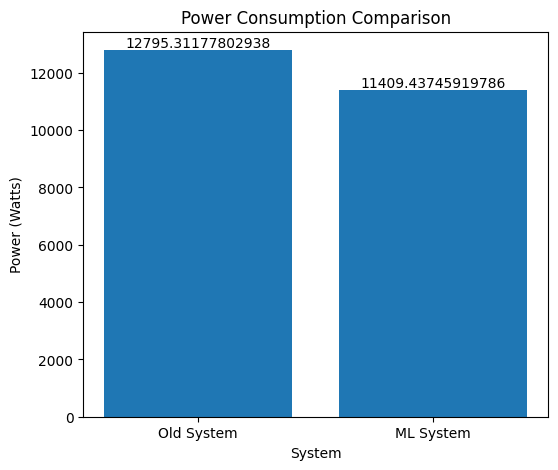

In [148]:
labels = ["Old System", "ML System"]
power_values = [old_power, new_power]

plt.figure(figsize=(6,5))

plt.bar(labels, power_values)

plt.title("Power Consumption Comparison")
plt.ylabel("Power (Watts)")
plt.xlabel("System")

for i, v in enumerate(power_values):
    plt.text(i, v + 100, str(v), ha='center')

plt.show()

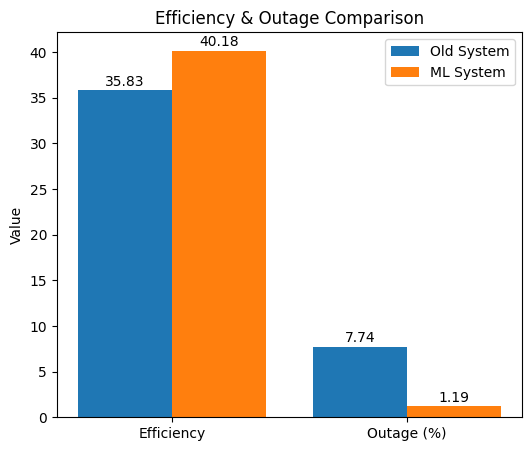

In [149]:
labels = ["Efficiency", "Outage (%)"]

old_values = [energy_eff_old, outage_prob_old * 100]
new_values = [energy_eff_new, outage_prob_new * 100]

x = np.arange(len(labels))

plt.figure(figsize=(6,5))

plt.bar(x-0.2, old_values, width=0.4, label="Old System")
plt.bar(x+0.2, new_values, width=0.4, label="ML System")

plt.xticks(x, labels)
plt.ylabel("Value")
plt.title("Efficiency & Outage Comparison")
plt.legend()

# Add values on top
for i, v in enumerate(old_values):
    plt.text(i-0.2, v + 0.5, round(v,2), ha='center')

for i, v in enumerate(new_values):
    plt.text(i+0.2, v + 0.5, round(v,2), ha='center')

plt.show()